In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import struct

__version__ = '0.01.00'

# Constants
GDFNAMELEN = 16                  # Length of the ascii-names
GDFID = 94325877                # ID for GDF

# Data types
t_undef = int('0000', 16)       # Data type not defined
t_ascii = int('0001', 16)       # ASCII character
t_s32 = int('0002', 16)       # Signed long
t_dbl = int('0003', 16)       # Double
t_null = int('0010', 16)       # No data
t_u8 = int('0020', 16)       # Unsigned char
t_s8 = int('0030', 16)       # Signed char
t_u16 = int('0040', 16)       # Unsigned short
t_s16 = int('0050', 16)       # Signed short
t_u32 = int('0060', 16)       # Unsigned long
t_u64 = int('0070', 16)       # Unsigned 64bit int
t_s64 = int('0080', 16)       # Signed 64bit int
t_flt = int('0090', 16)       # Float

# Block types
t_dir = 256      # Directory entry start
t_edir = 512      # Directory entry end
t_sval = 1024      # Single valued
t_arr = 2048      # Array


# Top level gdf readers
def gdftomemory(gdf_file):
    all = []

    def myprocfunc(params, data):
        all.append({'p': params, 'd': data})

    print(readgdf(gdf_file, myprocfunc))
    return all


def gdftopandas(gdf_file):
    params = []
    data = []
    paramid = 1

    def myprocfunc(blockparams, blockdata):
        nonlocal paramid

        temp = blockparams.copy()
        temp['paramid'] = paramid
        params.append(temp)

        temp = blockdata.copy()
        try:
            templen = len(next(iter(temp.values())))
            tempcol = np.full((templen, ), paramid)
            temp['paramid'] = tempcol
        except StopIteration:
            pass
        data.append(temp)

        paramid += 1

    header = readgdf(gdf_file, myprocfunc)

    params = pd.DataFrame(params)
    params.set_index('paramid', inplace=True)

    data = pd.concat([pd.DataFrame(blockdata) for blockdata in data],
                     sort=False)
    data.reset_index(drop=True, inplace=True)

    return header, params, data


# Internal functions
def _parseblocks(f, params, procfunc):
    data = {}
    while True:
        # TODO check end of file?
        # Read block header
        name = f.read(GDFNAMELEN)
        if len(name) == 0:
            procfunc(params, data)
            return
        name = name.decode().rstrip('\x00')
        type_, = struct.unpack('i', f.read(4))
        size, = struct.unpack('i', f.read(4))

        # Get block type and data type
        is_dir = (type_ & t_dir != 0)
        is_edir = (type_ & t_edir != 0)
        is_sval = (type_ & t_sval != 0)
        is_arr = (type_ & t_arr != 0)

        dattype = type_ & 255

        # Get block data (scalar or array)
        if is_sval:
            if dattype == t_dbl:
                value = struct.unpack('d', f.read(8))[0]
            elif dattype == t_null:
                pass
            elif dattype == t_ascii:
                value = f.read(size).decode().rstrip('\x00')
            elif dattype == t_s32:
                value = struct.unpack('i', f.read(4))[0]
            else:
                print('unknown datatype of value!!!')
                print('name=', name)
                print('type=', type_)
                print('size=', size)
                print('dattype=', dattype)
                value = f.read(size)
        elif is_arr:
            if dattype == t_dbl:
                value = np.frombuffer(f.read(size))
                data[name] = value
            else:
                print('unknown datatype of value!!!')
                print('name=', name)
                print('type=', type_)
                print('size=', size)
                print('dattype=', dattype)
                value = f.read(size)

        # Take care of recursion
        if is_dir:
            myparams = params.copy()
            myparams[name] = value
            _parseblocks(f, myparams, procfunc)
        elif is_edir:
            procfunc(params, data)
            return
        elif is_sval:
            params[name] = value


def _proc_print(params, data):
    print(params)
    print(data.keys())
    print('_____________________')


# Base gdf reader
def readgdf(gdf_file, procfunc=_proc_print):
    # Output data
    gdf_head = {}

    with open(gdf_file, 'rb') as f:
        # Read the GDF main header
        gdf_id_check = struct.unpack('i', f.read(4))[0]
        if gdf_id_check != GDFID:
            raise RuntimeWarning('File is not a .gdf file')

        time_created = struct.unpack('i', f.read(4))[0]
        time_created = datetime.fromtimestamp(time_created)
        gdf_head['time_created'] = time_created.isoformat(' ')

        gdf_head['creator'] = f.read(GDFNAMELEN).decode().rstrip('\x00')

        gdf_head['destination'] = f.read(GDFNAMELEN).decode().rstrip('\x00')

        major = struct.unpack('B', f.read(1))[0]
        minor = struct.unpack('B', f.read(1))[0]
        gdf_head['gdf_version'] = str(major) + '.' + str(minor)

        major = struct.unpack('B', f.read(1))[0]
        minor = struct.unpack('B', f.read(1))[0]
        gdf_head['creator_version'] = str(major) + '.' + str(minor)

        major = struct.unpack('B', f.read(1))[0]
        minor = struct.unpack('B', f.read(1))[0]
        gdf_head['destination_version'] = str(major) + '.' + str(minor)

        f.seek(2, 1)   # skip 2 bytes to go to next block

        # Read GDF data blocks (starts recursive reading)
        _parseblocks(f, {}, procfunc)

    return gdf_head


In [11]:
OUTPUT_PATH = '/pscratch/sd/j/jcurcio/pcnn/Volume_Data/'

n_pixels = 256
c = 2.99792458e8  # Speed of light

data = gdftomemory("PINN_trainingData_03.gdf")


# Determine max height, max width, and max bunch length across all timesteps
z_max_range = 0
x_min = float("inf")
x_max = float("-inf")
y_min = float("inf")
y_max = float("-inf")

B_max_global = float("-inf")
J_max_global = float("-inf")

for step in range(len(data) - 1):
    x = np.array(data[step].get("d").get("x"))
    y = np.array(data[step].get("d").get("y"))
    z = np.array(data[step].get("d").get("z"))
    q = np.array(data[step].get("d").get("q"))

    # Create a mask for the real particles. We don't care about the dummy particles
    mask = q != 0
    x_real = x[mask]
    y_real = y[mask]
    z_real = z[mask]

    x_min = min(x_min, x_real.min())
    x_max = max(x_max, x_real.max())
    y_min = min(y_min, y_real.min())
    y_max = max(y_max, y_real.max())

    z_range = z_real.max() - z_real.min()

    if z_range > z_max_range:
        z_max_range = z_range

xbins = np.linspace(x_min, x_max, n_pixels + 1)
ybins = np.linspace(y_min, y_max, n_pixels + 1)

bin_volume = z_max_range * (xbins[1] - xbins[0]) * (ybins[1] - ybins[0])

print('xmin: ', x_min)
print('xmax: ', x_max)
print('ymin: ', y_min)
print('ymax: ', y_max)
print('z_range: ', z_max_range)

print(len(data))
print(len(data[0].get("d")))
print(data[0].get("d"))

# Begin calculating and binning data
for step in range(len(data)):
    # Retrieve data
    x = np.array(data[step].get("d").get("x"))
    y = np.array(data[step].get("d").get("y"))
    z = np.array(data[step].get("d").get("z"))
    q = np.array(data[step].get("d").get("q"))

    mask = q != 0
    z_real = z[mask]
    z_min_current = z_real.min()
    zbins = np.linspace(z_min_current, z_min_current + z_max_range, n_pixels + 1)

    # Retrieve data
    components = {
        "Ex": np.array(data[step].get("d").get("fEx")),
        "Ey": np.array(data[step].get("d").get("fEy")),
        "Ez": np.array(data[step].get("d").get("fEz")),
        "Bx": np.array(data[step].get("d").get("fBx")),  # fBx represents magnetic x
        "By": np.array(data[step].get("d").get("fBy")),
        "Bz": np.array(data[step].get("d").get("fBz")),
        "q": np.array(data[step].get("d").get("q")),
    }

    velocities = {
        "Bx": np.array(data[step].get("d").get("Bx")),
        "By": np.array(data[step].get("d").get("By")),
        "Bz": np.array(data[step].get("d").get("Bz")),
    }

    binning_result = {}



    # Binning
    for key, data_comp in components.items():
        if key == 'q':
            hist, _ = np.histogramdd((x[mask], y[mask], z[mask]), bins=[xbins, ybins, zbins], weights=data_comp[mask], density=True) # apply q != 0 mask to only bin real particles for rho
            binning_result[key] = hist
        else:
            hist, _ = np.histogramdd((x, y, z), bins=[xbins, ybins, zbins], weights=data_comp) # bin both real and dummy particles for E and B
            binning_result[key] = hist

    # Save each binned result as a file
    for component in components:
        binned = binning_result[component]
        np.save(OUTPUT_PATH + f'{component}_3D_vol_{n_pixels}_{step}.npy', binned)

    # Calculate J components
    Jx = components["q"][mask] * velocities["Bx"][mask] * c / bin_volume
    Jy = components["q"][mask] * velocities["By"][mask] * c / bin_volume
    Jz = components["q"][mask] * velocities["Bz"][mask] * c / bin_volume

    j_components = {
        "Jx": Jx,
        "Jy": Jy,
        "Jz": Jz,
    }

    # Bin J
    for j_key, j_data in j_components.items():
        hist, _ = np.histogramdd((x[mask], y[mask], z[mask]), bins=[xbins, ybins, zbins], weights=j_data, density=True)
        np.save(OUTPUT_PATH + f'{j_key}_3D_vol_{n_pixels}_{step}.npy', hist)


    # Find B and J max for normalization
    B_max_global = max(B_max_global, components["Bx"][mask].max(), components["By"][mask].max(), components["Bz"][mask].max())
    J_max_global = max(J_max_global, Jx.max(), Jy.max(), Jz.max())


np.save(OUTPUT_PATH + 'Bxyz_max.npy', B_max_global)
np.save(OUTPUT_PATH + 'J_max_max_all_128.npy', J_max_global)

print("Fixed bin volume:", bin_volume)
print("B_max_global:", B_max_global)
print("J_max_global:", J_max_global)

{'time_created': '2024-07-05 13:46:35', 'creator': 'MR', 'destination': '', 'gdf_version': '1.1', 'creator_version': '1.3', 'destination_version': '0.0'}
202
xmin:  -0.000524511592356779
xmax:  0.0005244785471739739
ymin:  -0.0005356632346170567
ymax:  0.0005413384044049486
z_range:  0.0002685141967746496
Fixed bin volume: 1.851548460369426e-14
B_max_global: 0.16646476783769779
J_max_global: 4.292585313939298


ValueError: cannot reshape array of size 5004 into shape (128,128,128)

{'time_created': '2024-07-20 19:06:55', 'creator': 'MR', 'destination': '', 'gdf_version': '1.1', 'creator_version': '1.3', 'destination_version': '0.0'}


KeyboardInterrupt: 

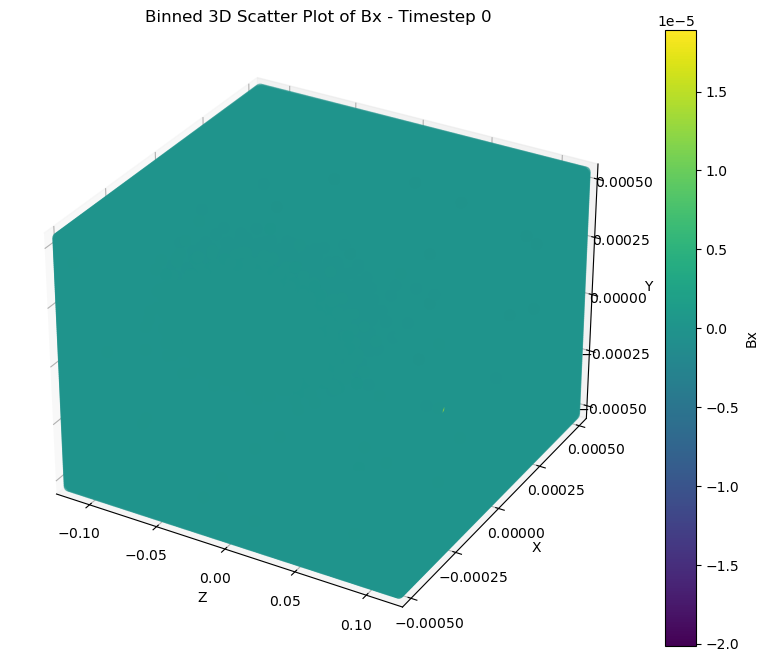

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from matplotlib.ticker import MaxNLocator, ScalarFormatter

OUTPUT_PATH = '/pscratch/sd/j/jcurcio/pcnn/Volume_Data/'

data = gdftomemory("PINN_trainingData_03.gdf")

# Assuming n_pixels is defined somewhere in your script
n_pixels = 128

# Assuming global min and max values are known for x and y
global_x_min = -0.000524511592356779
global_x_max = 0.0005244785471739739
global_y_min = -0.0005356632346170567
global_y_max = 0.0005413384044049486

def plot_variable(variable_name, data_length, xbins, ybins, data):
    filenames = []  # List to store filenames for deletion

    # Calculate the centers of the bins for x and y
    x_centers = 0.5 * (xbins[:-1] + xbins[1:])
    y_centers = 0.5 * (ybins[:-1] + ybins[1:])

    for i in range(data_length):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Load binned data from npy file for the chosen variable
        file_path = OUTPUT_PATH + f'{variable_name}_3D_vol_{n_pixels}_{i}.npy'

        # Check if the file exists to handle any missing files
        if not os.path.exists(file_path):
            binned_data = np.zeros((n_pixels, n_pixels, n_pixels))
            print(f"File not found, creating an all-zero placeholder for: {file_path}")
        else:
            binned_data = np.load(file_path)

        # Check if the binned data contains only zeros
        if np.all(binned_data == 0):
            print(f"File contains only zeros: {file_path}")

        # Retrieve the actual z data for the current timestep
        z_data = data[i].get("d").get("z")
        z = np.array(z_data)
        z_min_current = z.min()
        z_max_current = z.max()

        # Calculate the centers of the z bins for the current timestep
        zbins = np.linspace(z_min_current, z_max_current, n_pixels + 1)
        z_centers = 0.5 * (zbins[:-1] + zbins[1:])

        # Create meshgrid for plotting
        X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

        # Flatten arrays for plotting
        x_flattened = X.flatten()
        y_flattened = Y.flatten()
        z_flattened = Z.flatten()

        # Get non-zero indices for the chosen variable
        non_zero_indices = np.nonzero(binned_data.flatten())

        # Scatter plot of non-zero binned data points for the chosen variable
        if len(non_zero_indices[0]) > 0:
            sc = ax.scatter(z_flattened[non_zero_indices], x_flattened[non_zero_indices],
                            y_flattened[non_zero_indices], c=binned_data.flatten()[non_zero_indices],
                            cmap='viridis', s=50, vmin=binned_data.min(), vmax=binned_data.max())
            fig.colorbar(sc, label=variable_name)
        else:
            # Add a placeholder plot for all-zero data
            ax.text2D(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        # Set consistent axis limits for x and y
        ax.set_xlim(z_min_current, z_max_current)
        ax.set_ylim(global_x_min, global_x_max)
        ax.set_zlim(global_y_min, global_y_max)

        # Customize plot appearance
        ax.set_xlabel('Z')
        ax.set_ylabel('X')
        ax.set_zlabel('Y')
        ax.set_title(f'Binned 3D Scatter Plot of {variable_name} - Timestep {i}')

        # Adjust viewing angle
        ax.view_init(elev=30, azim=-60)

        # Format the tick labels to reduce precision
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.zaxis.set_major_locator(MaxNLocator(nbins=5))

        ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
        ax.zaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))

        # Save each plot as a PNG file
        filename = f'{variable_name}_timestep_{i}.png'
        plt.savefig(filename)
        plt.close(fig)  # Close the figure to release resources
        filenames.append(filename)
        print(f"Saved frame {i} as {filename}")

    # Generate the GIF from the saved PNG files
    gif_filename = f'{variable_name}_output.gif'
    with imageio.get_writer(gif_filename, mode='I', duration=0.1, loop=0) as writer:  # Set duration to 0.1 seconds per frame
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            print(f"Appended {filename} to GIF")

    print(f'GIF saved as {gif_filename}')

    # Remove the image files after creating the GIF
    for filename in filenames:
        os.remove(filename)

    print(f'Removed {len(filenames)} temporary PNG files.')

# Assuming 'data' is already defined and contains 200 timesteps
data_length = len(data) - 1

# Assuming xbins and ybins are defined
xbins = np.linspace(global_x_min, global_x_max, n_pixels + 1)
ybins = np.linspace(global_y_min, global_y_max, n_pixels + 1)

plot_variable('Bx', data_length, xbins, ybins, data)


In [13]:
# Save original data for prediction comparison purposes
OUTPUT_PATH = '/pscratch/sd/j/jcurcio/pcnn/Volume_Data/'
data = gdftomemory("PINN_trainingData_02.gdf")
step = 10

original_Bx_data = np.array(data[step].get("d").get("fBx"))
original_By_data = np.array(data[step].get("d").get("fBy"))
original_Bz_data = np.array(data[step].get("d").get("fBz"))

# Save the original Bx, By, and Bz data
np.save(OUTPUT_PATH + 'original_Bx_data.npy', original_Bx_data)
np.save(OUTPUT_PATH + 'original_By_data.npy', original_By_data)
np.save(OUTPUT_PATH + 'original_Bz_data.npy', original_Bz_data)

print("Original Bx, By, and Bz data saved.")

{'time_created': '2024-07-05 13:46:35', 'creator': 'MR', 'destination': '', 'gdf_version': '1.1', 'creator_version': '1.3', 'destination_version': '0.0'}
Original Bx, By, and Bz data saved.


{'time_created': '2024-07-20 19:06:55', 'creator': 'MR', 'destination': '', 'gdf_version': '1.1', 'creator_version': '1.3', 'destination_version': '0.0'}
(-0.3514833333544636, 0.3514897337473077)


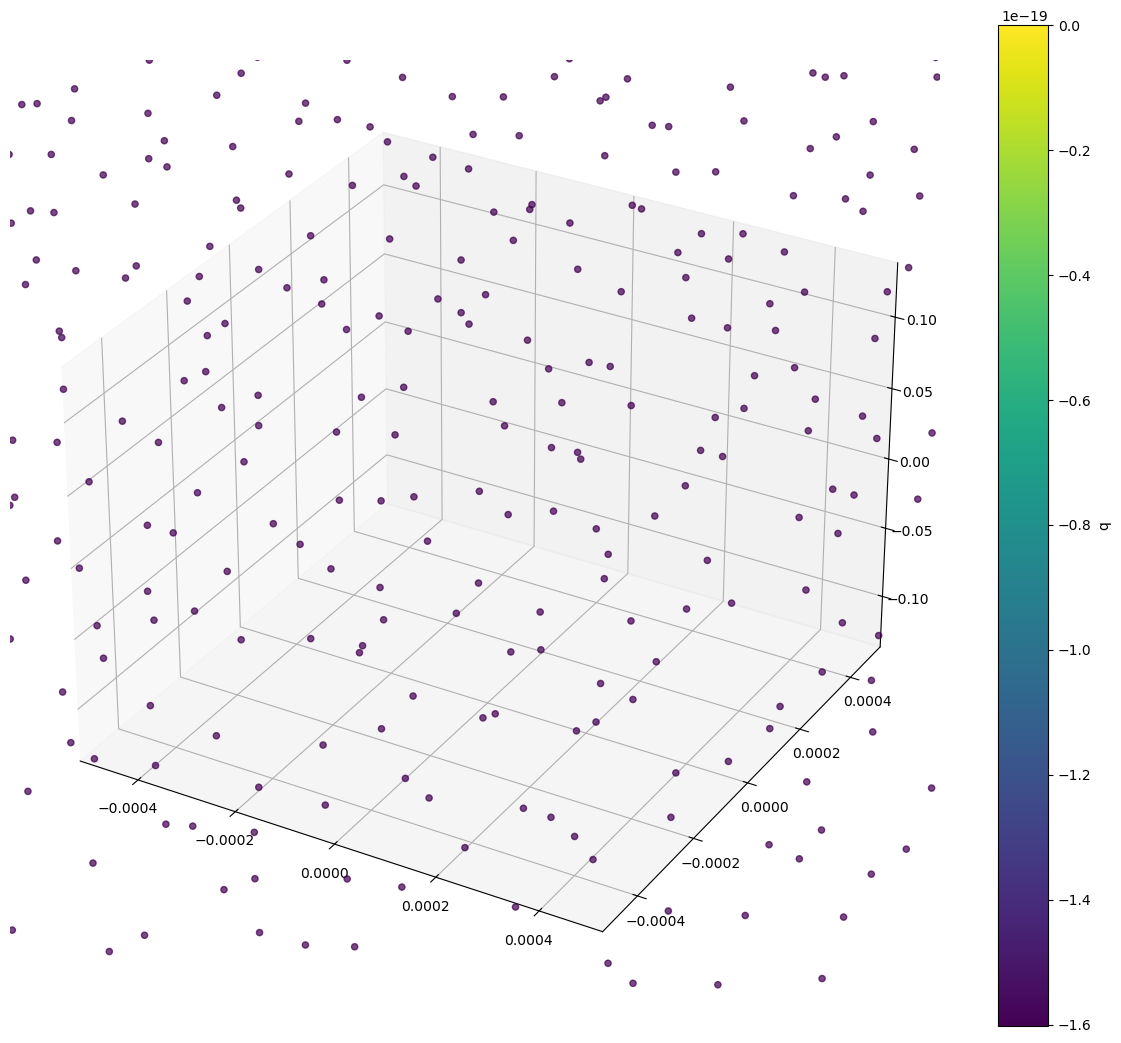

(-0.3514833333544636, 0.3514897337473077)


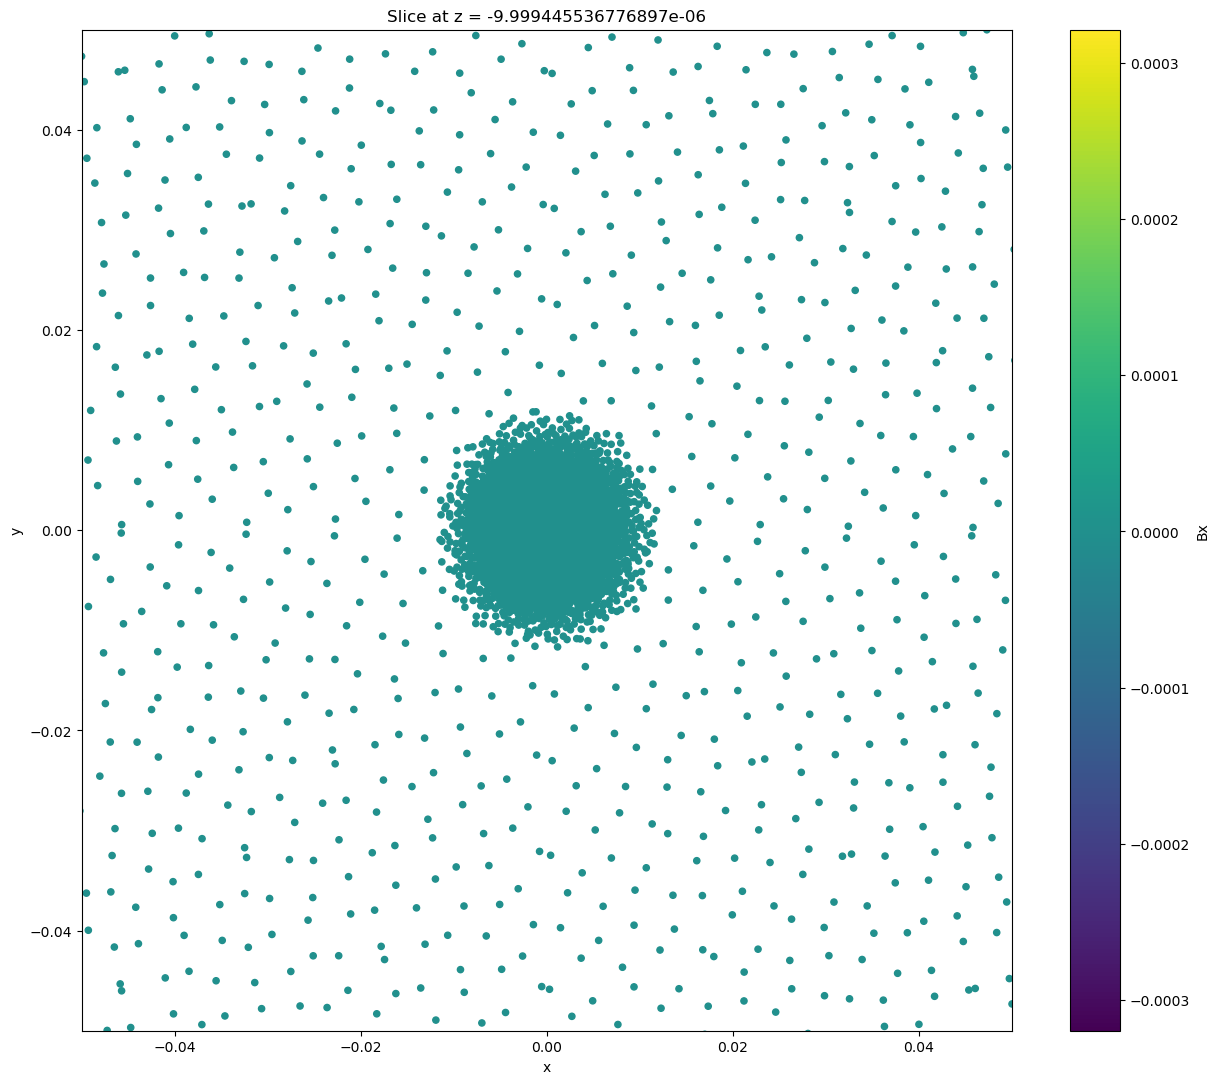

In [28]:
# PLOT ORIGINAL DATA

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator, ScalarFormatter

n_pixels = 128

data = gdftomemory("PINN_trainingData_03.gdf")

x = np.array(data[0].get("d").get("x"))
y = np.array(data[0].get("d").get("y"))
z = np.array(data[0].get("d").get("z"))

Bx = np.array(data[0].get("d").get("fBx"))
By = np.array(data[0].get("d").get("fBy"))
Bz = np.array(data[0].get("d").get("fBz"))

Ex = np.array(data[0].get("d").get("fEx"))
Ey = np.array(data[0].get("d").get("fEy"))
Ez = np.array(data[0].get("d").get("fEz"))

q = np.array(data[0].get("d").get("q"))

fig = plt.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=q, cmap='viridis', s=20, vmin=q.min(), vmax=q.max(), label='q')
fig.colorbar(sc, label='q')

print(plt.ylim())
plt.ylim(-0.0005, 0.0005)
plt.xlim(-0.0005, 0.0005)


plt.show()


# Filter data for z
slice_indices = z.any() > 0.13727 or z.any() < 0.13733
x_slice = x[slice_indices]
y_slice = y[slice_indices]
Bx_slice = Bx[slice_indices]
q_slice = q[slice_indices]

# Plot the slice at z = 64
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111)

sc = ax.scatter(x_slice, y_slice, c=q_slice, cmap='viridis', s=20, vmin=Bx.min(), vmax=Bx.max(), label='Bx')
fig.colorbar(sc, label='Bx')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Slice at z = {np.median(z)}')

print(plt.ylim())
plt.ylim(-0.05, 0.05)
plt.xlim(-0.05, 0.05)

plt.show()